
# Bold Dashed-Line Detector — Steps 1–4 (Raster-first)

This notebook implements a **sample-driven** pipeline for detecting **bold dashed lines** in scanned floor plans.

**What you'll do:**
1. Select a **clean ROI** over a dashed line (rectangle tool).
2. The notebook will **learn** stroke width `w`, dash `d` and gap `g` from the sample.
3. It **preprocesses** the whole image (contrast + binarize).
4. It detects **bold dashed** candidates (width gating + matched filters).
5. It **links** them into polylines (skeleton + tracing) and shows overlays.

> Note: No scaling or length calculations here (that's Step 5; intentionally omitted per your request).


Loaded image: rightside.png shape: (1935, 2172)


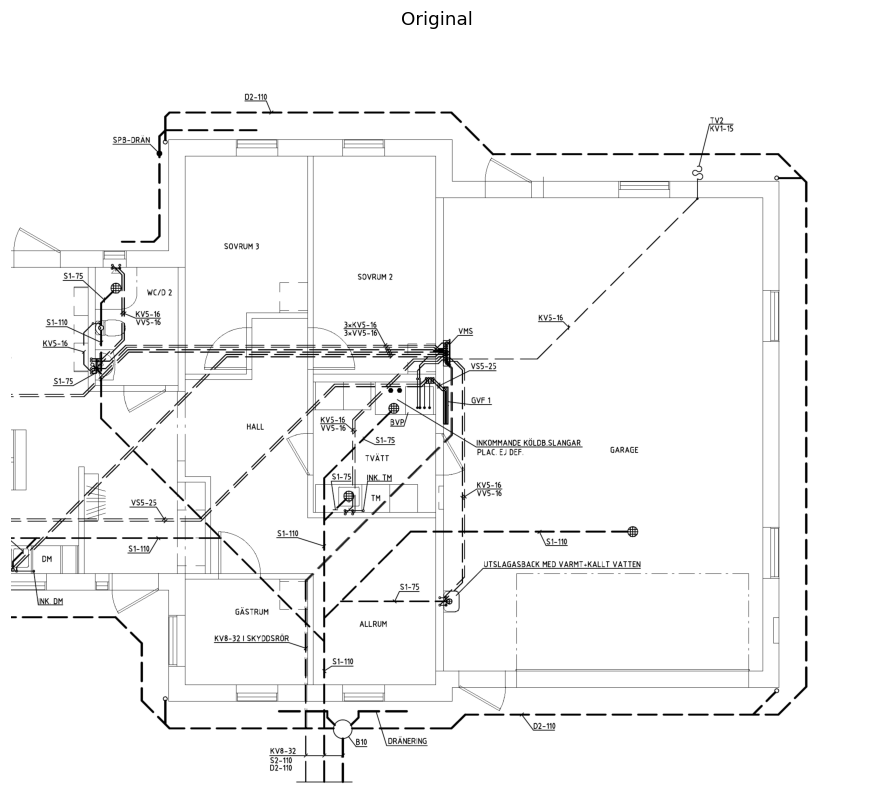

In [8]:

# --- Imports & configuration ---
import os, json, math
import numpy as np
import cv2
import matplotlib.pyplot as plt

from matplotlib.widgets import RectangleSelector
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops
from scipy.signal import find_peaks

# For crisp plots
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['figure.dpi'] = 110

# ---- INPUT IMAGE ----
# Change this path if you run the notebook elsewhere
IMG_PATH = 'rightside.png'

assert os.path.exists(IMG_PATH), f'Image not found: {IMG_PATH}'
img_gray = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)

print('Loaded image:', IMG_PATH, 'shape:', img_gray.shape)
plt.imshow(img_gray, cmap='gray'); plt.axis('off'); plt.title('Original'); plt.show()



## Step 1 — Select ROI (dash template)
Draw a rectangle around a **clean segment** of the target dashed line, then press **Enter** to confirm.


Full image shape: (3509, 4963)
Sample shape: (121, 484)


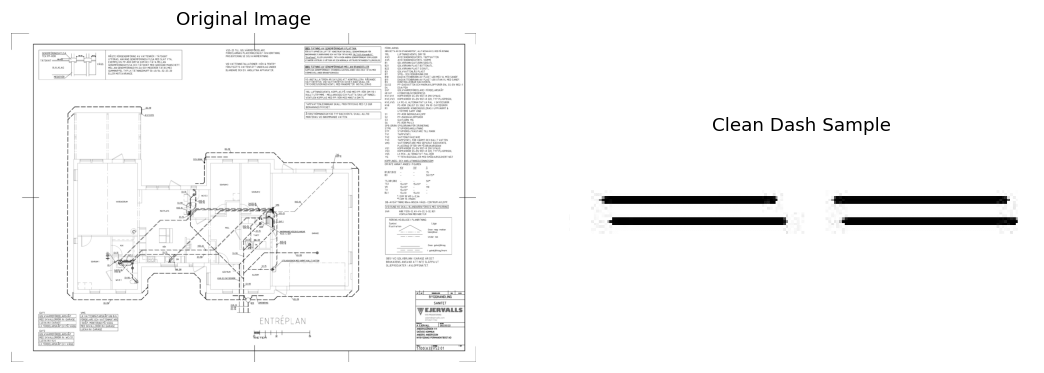

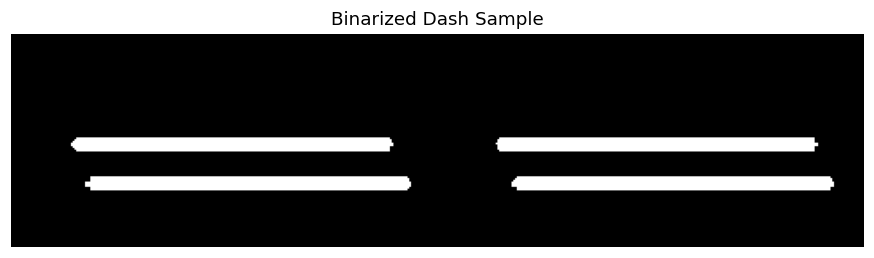

Estimated stroke width ~ 3.82 px


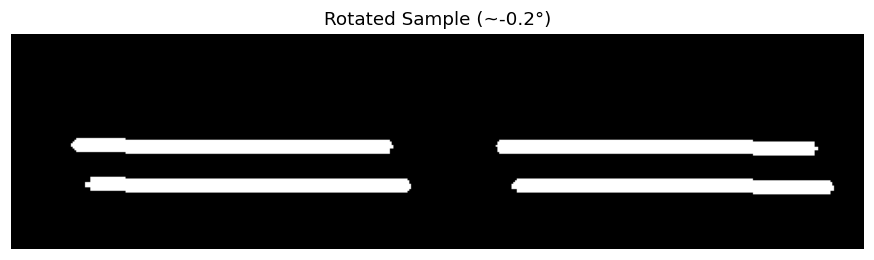

Estimated period ~ 242.00 px
Estimated dash length ~ 191.00 px
Estimated gap length  ~ 51.00 px


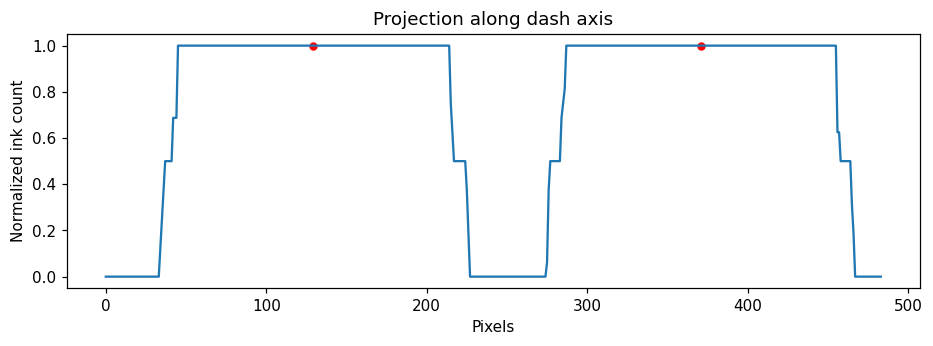

In [9]:
## Step 1 — Load provided dash sample image
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.signal import find_peaks

# Paths to files
IMG_PATH = "page_1.png"          # full floorplan
SAMPLE_PATH = "full-double-dash-h.png"     # cropped clean dash example

# Load both
img_gray = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
roi = cv2.imread(SAMPLE_PATH, cv2.IMREAD_GRAYSCALE)

print("Full image shape:", img_gray.shape)
print("Sample shape:", roi.shape)

# Show both
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(img_gray, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')
axs[1].imshow(roi, cmap='gray')
axs[1].set_title('Clean Dash Sample')
axs[1].axis('off')
plt.show()

# --- Learn stroke width, dash length, gap ---
# Binarize sample
roi_blur = cv2.GaussianBlur(roi, (3,3), 0)
_, roi_bin = cv2.threshold(roi_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

plt.imshow(roi_bin, cmap='gray')
plt.axis('off')
plt.title('Binarized Dash Sample')
plt.show()

# Stroke width
dist = cv2.distanceTransform(roi_bin, cv2.DIST_L2, 3)
stroke_width = float(np.median(dist[roi_bin > 0]) * 2.0)
stroke_width = max(1.0, stroke_width)
print(f"Estimated stroke width ~ {stroke_width:.2f} px")

# Orientation
ys, xs = np.where(roi_bin > 0)
cov = np.cov(xs, ys)
eigvals, eigvecs = np.linalg.eig(cov)
main_axis = eigvecs[:, np.argmax(eigvals)]
angle_rad = math.atan2(main_axis[1], main_axis[0])
angle_deg = np.degrees(angle_rad)

# --- Rotate so dash is horizontal without cropping ---
# Compute center and needed bounding box size after rotation
h, w = roi_bin.shape
center = (w // 2, h // 2)
angle_deg = -np.degrees(angle_rad)

# Compute rotation matrix
M = cv2.getRotationMatrix2D(center, angle_deg, 1.0)

# Compute new bounding dimensions
cos = abs(M[0, 0])
sin = abs(M[0, 1])
new_w = int((h * sin) + (w * cos))
new_h = int((h * cos) + (w * sin))

# Adjust translation in the rotation matrix
M[0, 2] += (new_w / 2) - center[0]
M[1, 2] += (new_h / 2) - center[1]

# Rotate on padded canvas
roi_rot = cv2.warpAffine(roi_bin, M, (new_w, new_h), flags=cv2.INTER_NEAREST, borderValue=0)

plt.imshow(roi_rot, cmap='gray')
plt.axis('off')
plt.title(f'Rotated Sample (~{angle_deg:.1f}°)')
plt.show()


# Projection to find dash/gap
proj = np.sum(roi_rot > 0, axis=0).astype(np.float32)
proj = (proj - proj.min()) / (proj.max() - proj.min() + 1e-6)
peaks, _ = find_peaks(proj, height=0.3, distance=max(2, int(stroke_width)))
period_px = np.median(np.diff(peaks)) if len(peaks) > 1 else np.nan

dash_widths = []
th = 0.3
for p in peaks:
    left = p
    while left > 0 and proj[left] > th: left -= 1
    right = p
    while right < len(proj)-1 and proj[right] > th: right += 1
    dash_widths.append(right - left)

dash_len = float(np.median(dash_widths)) if dash_widths else float('nan')
gap_len = float(period_px - dash_len) if (dash_len==dash_len and period_px==period_px) else float('nan')

print(f"Estimated period ~ {period_px:.2f} px")
print(f"Estimated dash length ~ {dash_len:.2f} px")
print(f"Estimated gap length  ~ {gap_len:.2f} px")

# Plot projection profile
plt.figure(figsize=(10, 3))
plt.plot(proj)
if len(peaks):
    plt.scatter(peaks, proj[peaks], s=20, c='red')
plt.title('Projection along dash axis')
plt.xlabel('Pixels')
plt.ylabel('Normalized ink count')
plt.show()



## Step 1b — Learn stroke width, dash and gap from ROI
We binarize the ROI, estimate **stroke width** from the distance transform, and estimate **dash/gap** by projecting
intensity along the dominant axis and finding periodic peaks.


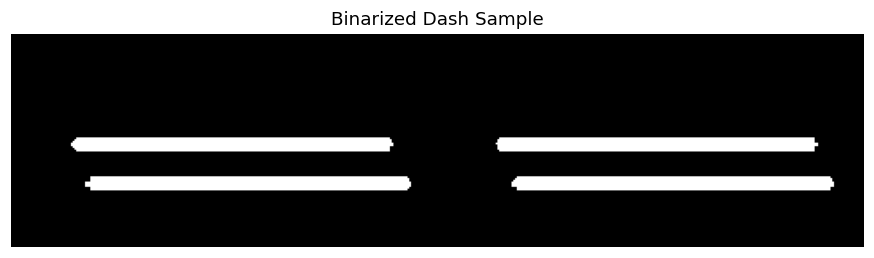

Estimated stroke width ~ 3.82 px


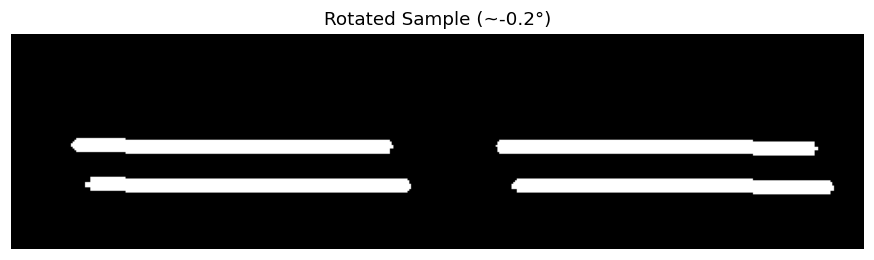

Estimated period     ~ 242.00 px
Estimated dash len  ~ 191.00 px
Estimated gap len   ~ 51.00 px


In [10]:
## Step 1b — Learn stroke width, dash and gap from sample
import cv2
import numpy as np
import math
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# --- Binarize sample (invert so ink=1) ---
roi_blur = cv2.GaussianBlur(roi, (3,3), 0)
_, roi_bin = cv2.threshold(
    roi_blur, 0, 255,
    cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
)

plt.imshow(roi_bin, cmap='gray')
plt.axis('off')
plt.title('Binarized Dash Sample')
plt.show()

# --- Stroke width via distance transform ---
dist = cv2.distanceTransform(roi_bin, cv2.DIST_L2, 3)
stroke_width = float(np.median(dist[roi_bin > 0]) * 2.0)
stroke_width = max(1.0, stroke_width)
print(f"Estimated stroke width ~ {stroke_width:.2f} px")

# --- Orientation estimation ---
ys, xs = np.where(roi_bin > 0)
if len(xs) < 50:
    raise RuntimeError("Sample too small or too few ink pixels.")

cov = np.cov(xs, ys)
eigvals, eigvecs = np.linalg.eig(cov)
main_axis = eigvecs[:, np.argmax(eigvals)]
angle_rad = math.atan2(main_axis[1], main_axis[0])
angle_deg = -np.degrees(angle_rad)  # negative for cv2 rotation

# --- Rotate with padding to avoid cropping ---
h, w = roi_bin.shape
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle_deg, 1.0)
cos = abs(M[0, 0])
sin = abs(M[0, 1])
new_w = int((h * sin) + (w * cos))
new_h = int((h * cos) + (w * sin))
M[0, 2] += (new_w / 2) - center[0]
M[1, 2] += (new_h / 2) - center[1]
roi_rot = cv2.warpAffine(
    roi_bin, M, (new_w, new_h),
    flags=cv2.INTER_NEAREST, borderValue=0
)

plt.imshow(roi_rot, cmap='gray')
plt.axis('off')
plt.title(f'Rotated Sample (~{angle_deg:.1f}°)')
plt.show()

# --- Projection along the dash axis ---
proj = np.sum(roi_rot > 0, axis=0).astype(np.float32)
proj = (proj - proj.min()) / (proj.max() - proj.min() + 1e-6)

# --- Peak detection to estimate period ---
peaks, _ = find_peaks(
    proj, height=0.3,
    distance=max(2, int(stroke_width))
)
period_px = np.median(np.diff(peaks)) if len(peaks) > 1 else np.nan

# --- Dash length from peak widths ---
dash_widths = []
th = 0.3
for p in peaks:
    left = p
    while left > 0 and proj[left] > th:
        left -= 1
    right = p
    while right < len(proj)-1 and proj[right] > th:
        right += 1
    dash_widths.append(right - left)

dash_len = float(np.median(dash_widths)) if dash_widths else float('nan')
gap_len = float(period_px - dash_len) if (
    dash_len == dash_len and period_px == period_px
) else float('nan')

print(f"Estimated period     ~ {period_px:.2f} px")
print(f"Estimated dash len  ~ {dash_len:.2f} px")
print(f"Estimated gap len   ~ {gap_len:.2f} px")

# --- Visualize projection pro



## Step 2 — Preprocess full image
Light contrast equalization + Otsu binarization (ink becomes white in the binary mask).


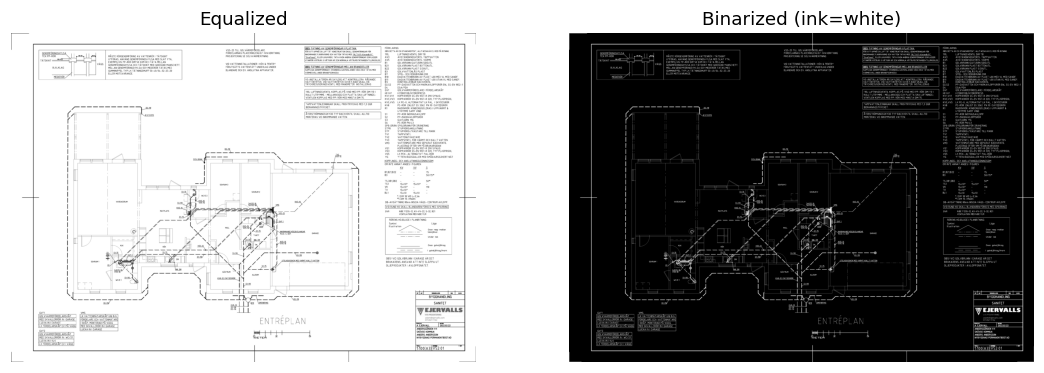

In [11]:

# CLAHE for gentle contrast normalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_eq = clahe.apply(img_gray)

# Binary ink mask (ink=1)
_, img_bin = cv2.threshold(img_eq, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

f, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(img_eq, cmap='gray'); ax[0].set_title('Equalized'); ax[0].axis('off')
ax[1].imshow(img_bin, cmap='gray'); ax[1].set_title('Binarized (ink=white)'); ax[1].axis('off')
plt.show()



## Step 3 — Width gating (boldness filter)
Compute distance transform on the binary mask and keep pixels whose **local stroke width**
matches the ROI's stroke width ± tolerance.


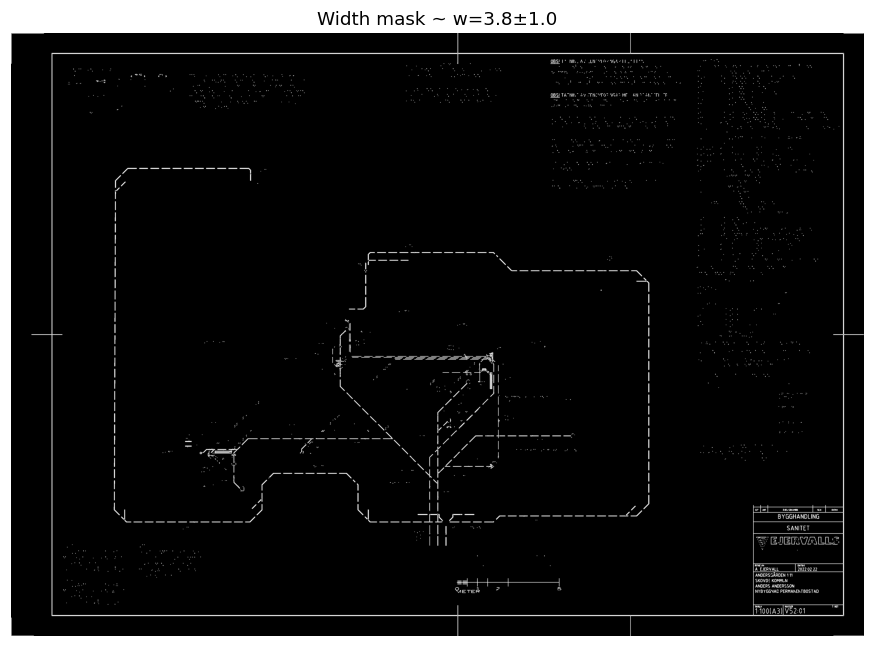

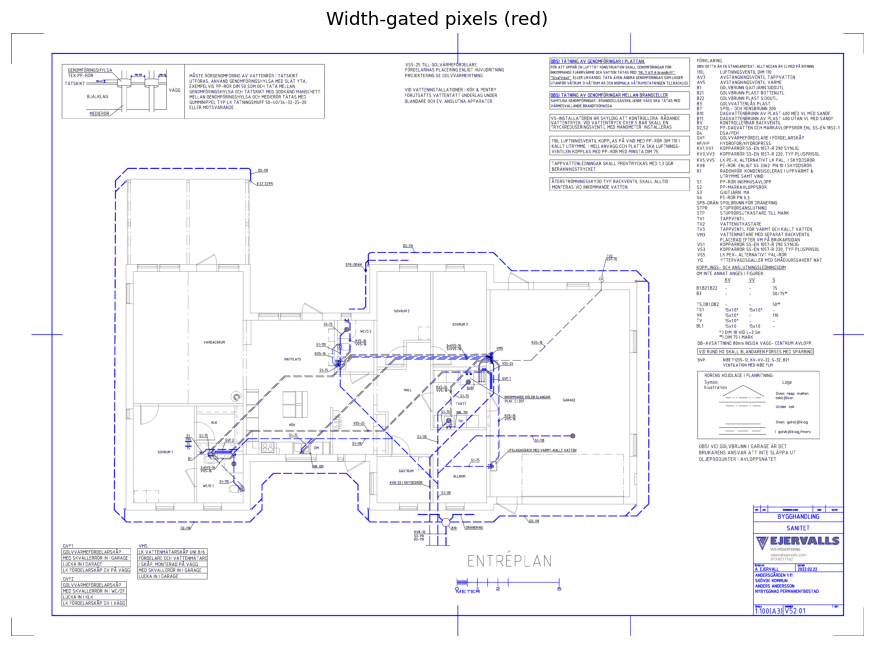

In [12]:

# Distance transform on full image
dist_full = cv2.distanceTransform(img_bin, cv2.DIST_L2, 3)

# Tolerance around stroke width
tol = max(1.0, 0.15 * stroke_width)
lower = max(0.5, (stroke_width/2.0) - tol)
upper = (stroke_width/2.0) + tol

mask_width = ((dist_full >= lower) & (dist_full <= upper)).astype(np.uint8)

# Clean small speckles
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
mask_width = cv2.morphologyEx(mask_width, cv2.MORPH_OPEN, kernel, iterations=1)

plt.imshow(mask_width, cmap='gray'); plt.axis('off'); plt.title(f'Width mask ~ w={stroke_width:.1f}±{tol:.1f}'); plt.show()

# Overlay preview
overlay = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
ys, xs = np.where(mask_width>0)
overlay[ys, xs] = [0, 0, 255]
plt.imshow(overlay); plt.axis('off'); plt.title('Width-gated pixels (red)'); plt.show()



## Step 3b — Oriented matched filtering
Apply a bank of short thick **line kernels** (length≈dash, thickness≈w) at multiple orientations
to emphasize segments aligned like the sample dashes.


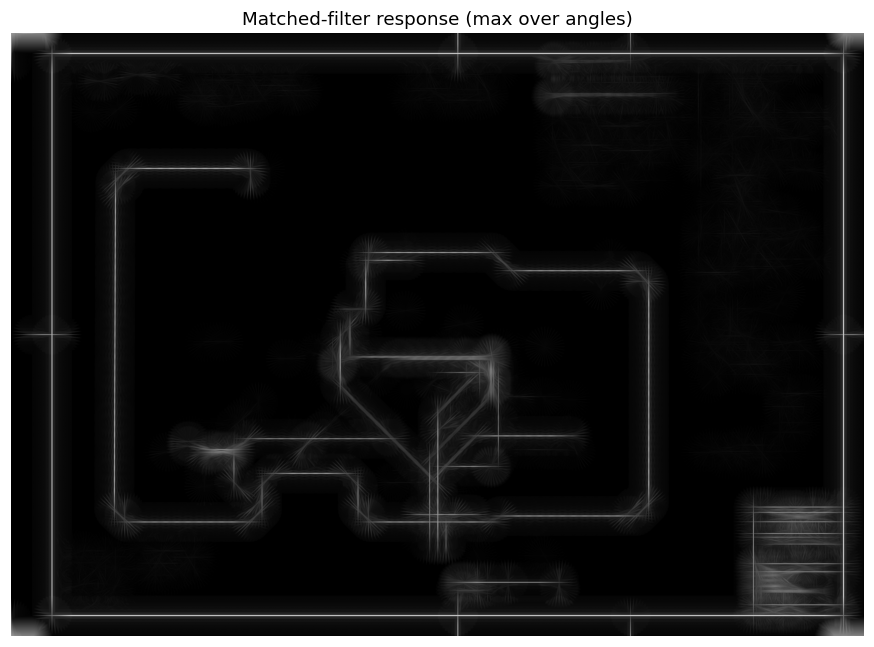

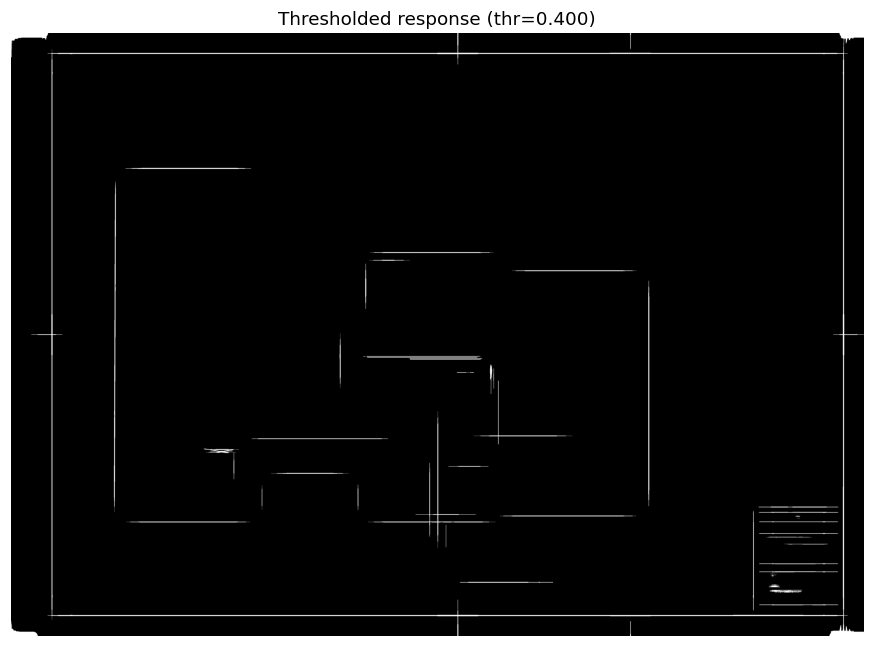

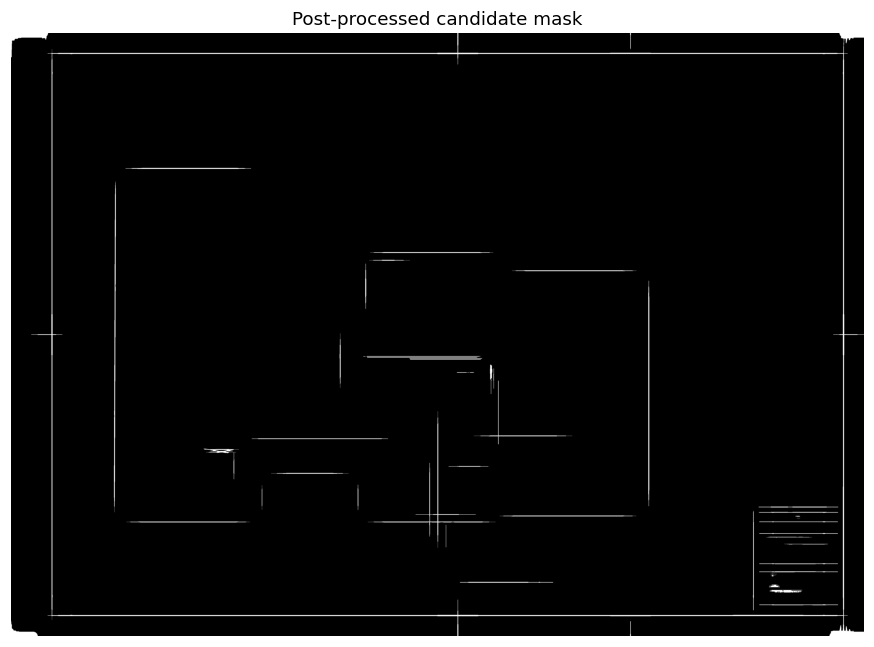

In [13]:

def make_line_kernel(length, thickness, angle_deg):
    size = max(int(length*1.5), int(thickness*6), 9)
    if size % 2 == 0: size += 1
    kern = np.zeros((size, size), np.float32)
    cv2.line(kern, (size//10, size//2), (size - size//10, size//2), 1.0, int(max(1, round(thickness))))
    M = cv2.getRotationMatrix2D((size//2, size//2), angle_deg, 1.0)
    kern = cv2.warpAffine(kern, M, (size, size))
    # normalize kernel energy
    s = kern.sum() + 1e-6
    return kern / s

# pick length fallback if dash_len is nan
dash_for_kernel = dash_len if dash_len==dash_len and dash_len>2 else max(6, stroke_width*3)
angles = np.arange(0, 180, 10.0)

resp_max = np.zeros_like(dist_full, dtype=np.float32)
for ang in angles:
    k = make_line_kernel(dash_for_kernel, stroke_width, ang)
    r = cv2.filter2D(mask_width.astype(np.float32), -1, k, borderType=cv2.BORDER_REPLICATE)
    resp_max = np.maximum(resp_max, r)

# Threshold relative to local max
thr = 0.4 * resp_max.max()
match_mask = (resp_max >= thr).astype(np.uint8)

plt.imshow(resp_max, cmap='gray'); plt.axis('off'); plt.title('Matched-filter response (max over angles)'); plt.show()
plt.imshow(match_mask, cmap='gray'); plt.axis('off'); plt.title(f'Thresholded response (thr={thr:.3f})'); plt.show()

# Directional closing to connect small gaps along orientations
se = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
match_mask = cv2.morphologyEx(match_mask, cv2.MORPH_CLOSE, se, iterations=1)

plt.imshow(match_mask, cmap='gray'); plt.axis('off'); plt.title('Post-processed candidate mask'); plt.show()



## Step 4 — Skeletonize and trace polylines
We skeletonize the candidate mask and extract connected paths as polylines. For a quick visual,
we plot the skeleton over the original.


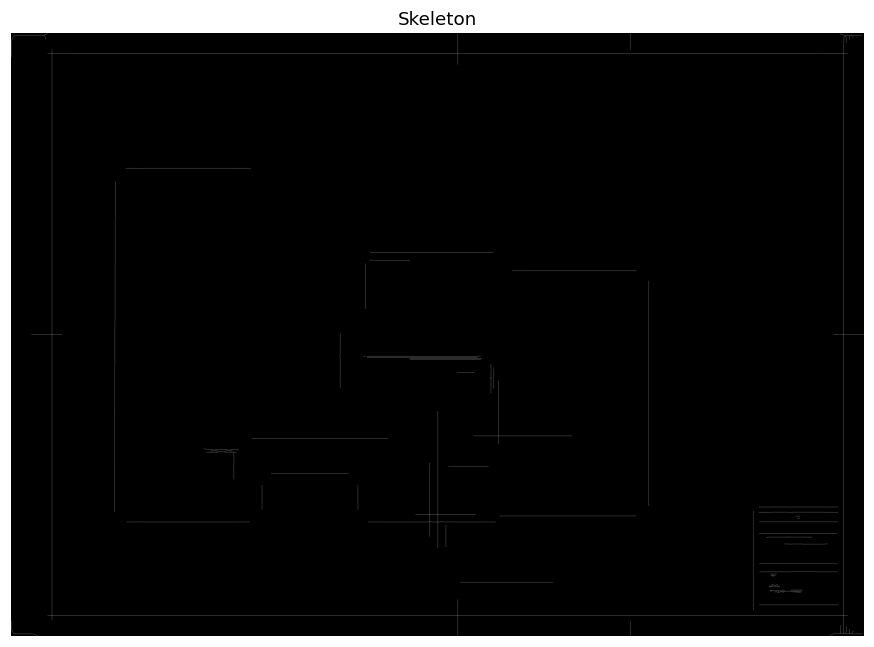

In [ ]:
## Step 4 — Skeletonize and trace polylines
from skimage.morphology import skeletonize
from collections import deque
import cv2
import matplotlib.pyplot as plt

# Skeleton from detected mask
skel = skeletonize(match_mask > 0).astype(np.uint8)

plt.imshow(skel, cmap='gray')
plt.axis('off')
plt.title('Skeleton')
plt.show()

# Trace skeleton into ordered polylines
H, W = skel.shape
visited = np.zeros_like(skel, dtype=bool)

def neighbors(y, x):
    for dy in (-1, 0, 1):
        for dx in (-1, 0, 1):
            if dy == 0 and dx == 0:
                continue
            ny, nx = y + dy, x + dx
            if 0 <= ny < H and 0 <= nx < W and skel[ny, nx]:
                yield ny, nx

def degree(y, x):
    return sum(1 for _ in neighbors(y, x))

polylines = []

def trace_from(start):
    path = [start]
    y, x = start
    visited[y, x] = True
    nbrs = [n for n in neighbors(y, x) if not visited[n]]
    if not nbrs:
        return path
    y, x = nbrs[0]
    path.append((y, x))
    visited[y, x] = True
    while True:
        nbrs = [n for n in neighbors(y, x) if not visited[n]]
        if not nbrs:
            break
        if len(nbrs) == 1:
            y, x = nbrs[0]
            path.append((y, x))
            visited[y, x] = True
        else:
            break
    return path

# Trace from endpoints
for sy in range(H):
    for sx in range(W):
        if skel[sy, sx] and not visited[sy, sx] and degree(sy, sx) == 1:
            poly = trace_from((sy, sx))
            if len(poly) >= 10:
                polylines.append(poly)

# Also collect any leftover loops
for sy in range(H):
    for sx in range(W):
        if skel[sy, sx] and not visited[sy, sx]:
            poly = trace_from((sy, sx))
            if len(poly) >= 10:
                polylines.append(poly)

print('Polylines traced:', len(polylines))

# Overlay visualization
overlay = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
for poly in polylines:
    for (y, x) in poly:
        overlay[y, x] = (0, 0, 255)  # red

plt.imshow(overlay)
plt.axis('off')
plt.title('Detected dashed-line polylines (red overlay)')
plt.show()
